# FET445 – Veri Madenciliği  
## Wisam AlMohamed – Temel Model Geliştirme (Base Modeller + Özellik Seçimi + Boyut İndirgeme)

Bu notebook, **Depression Dataset** üzerinde çalışarak:
- Ortak veri keşfi (EDA) ve ön işleme adımlarını,
- Wisam'ın sorumlu olduğu **özellik seçimi (Feature Selection)** tekniklerini,
- **Boyut indirgeme (Dimensionality Reduction)** adımlarını,
- Ve bunların farklı **temel (base) modeller üzerindeki etkisini** göstermektedir.

Hedef değişken (**target**): `History of Mental Illness`  
Görev türü: **İkili sınıflandırma (binary classification)**.


## 1. Problem Tanımı

Bu projede amaç, bireylerin yaşam tarzı, demografik özellikleri ve sağlık durumları gibi
değişkenleri kullanarak, geçmişte herhangi bir psikolojik rahatsızlık yaşayıp yaşamadıklarını
tahmin etmektir.

Bu notebook'ta Wisam'ın katkısı:
- Ortak veri ön işleme pipeline'ının kullanılması,
- Farklı **özellik seçimi** tekniklerinin denenmesi:
  - `SelectKBest(chi2)`
  - `SelectKBest(mutual_info_classif)`
- `PCA` ile boyut indirgeme,
- İki temel modelin kullanılması:
  - Lojistik Regresyon (`LogisticRegression`)
  - Karar Ağacı (`DecisionTreeClassifier`),
- Ve tüm aşamalar için **performans karşılaştırması** yapılmasıdır.


## 2. Kurulum ve Gerekli Kütüphaneler

Bu bölümde veri işleme, modelleme ve değerlendirme için gerekli Python kütüphaneleri yüklenmektedir.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)


## 3. Veri Setini Yükleme

Bu projede Kaggle üzerinde yer alan **Depression Dataset** kullanılmaktadır.  
Lütfen aynı klasörde veri dosyasının adını uygun şekilde ayarlayın.

- Önerilen dosya adı: `depression_data.csv` veya `depression-dataset.csv`
- Hedef sütun: `History of Mental Illness`


In [2]:
CSV_PATH = "depression_data.csv"  # Gerekirse dosya adını değiştir
TARGET_COL = "History of Mental Illness"

# Veriyi oku
df = pd.read_csv(CSV_PATH)

# Hedef sütunu 0/1'e çeviriyoruz: No -> 0, Yes -> 1
df[TARGET_COL] = df[TARGET_COL].map({"No": 0, "Yes": 1})

print("Veri şekli (satır, sütun):", df.shape)
df.head()



Veri şekli (satır, sütun): (413768, 16)


,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,1,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,1,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,0,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,0,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,1,No,Yes,Yes


## 4. Veri Setinin Genel Özeti

Bu bölümde veri setinin temel yapısı incelenmektedir:
- Sütun isimleri ve veri tipleri
- Sayısal ve kategorik sütunların ayrımı


In [3]:
# Sütun bilgileri
print("Sütun tipleri:\n")
print(df.dtypes)

print("\nİlk 5 gözlem:")
df.head()


Sütun tipleri:

Name                             object
Age                               int64
Marital Status                   object
Education Level                  object
Number of Children                int64
Smoking Status                   object
Physical Activity Level          object
Employment Status                object
Income                          float64
Alcohol Consumption              object
Dietary Habits                   object
Sleep Patterns                   object
History of Mental Illness         int64
History of Substance Abuse       object
Family History of Depression     object
Chronic Medical Conditions       object
dtype: object

İlk 5 gözlem:


,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,1,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,1,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,0,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,0,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,1,No,Yes,Yes


## 5. Eksik Değer Analizi ve Hedef Değişkenin Dağılımı

Modelleme öncesi:
- Hangi sütunlarda eksik veri var?
- Hedef sınıflar dengeli mi, dengesiz mi?


Eksik değer sayıları:

Name                            0
Age                             0
Marital Status                  0
Education Level                 0
Number of Children              0
Smoking Status                  0
Physical Activity Level         0
Employment Status               0
Income                          0
Alcohol Consumption             0
Dietary Habits                  0
Sleep Patterns                  0
History of Mental Illness       0
History of Substance Abuse      0
Family History of Depression    0
Chronic Medical Conditions      0
dtype: int64

Hedef değişken dağılımı (adet):
History of Mental Illness
0    287943
1    125825
Name: count, dtype: int64

Hedef değişken dağılımı (oran):
History of Mental Illness
0    0.695904
1    0.304096
Name: proportion, dtype: float64


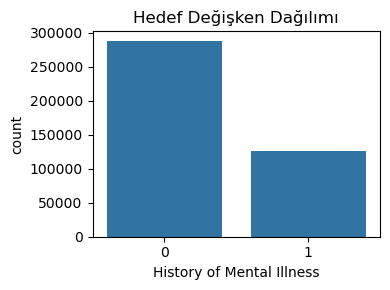

In [4]:
# Eksik değer sayıları
print("Eksik değer sayıları:\n")
print(df.isna().sum())

# Hedef değişken dağılımı
print("\nHedef değişken dağılımı (adet):")
print(df[TARGET_COL].value_counts())

print("\nHedef değişken dağılımı (oran):")
print(df[TARGET_COL].value_counts(normalize=True))

# İsteğe bağlı görselleştirme
plt.figure(figsize=(4,3))
sns.countplot(x=TARGET_COL, data=df)
plt.title("Hedef Değişken Dağılımı")
plt.tight_layout()
plt.show()


## 6. Özellik Türlerini Belirleme (Sayısal vs. Kategorik)

Makine öğrenmesi modelleri için sayısal ve kategorik sütunlara farklı ön işleme
adımları uygulanacaktır.

- Sayısal sütunlar: Ölçeklendirme (scaling)
- Kategorik sütunlar: One-Hot Encoding


In [5]:
# Özellik ve hedef ayrımı
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# Sayısal ve kategorik sütunları otomatik bul
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("Sayısal sütunlar:", num_cols)
print("Kategorik sütunlar:", cat_cols)



Sayısal sütunlar: ['Age', 'Number of Children', 'Income']
Kategorik sütunlar: ['Name', 'Marital Status', 'Education Level', 'Smoking Status', 'Physical Activity Level', 'Employment Status', 'Alcohol Consumption', 'Dietary Habits', 'Sleep Patterns', 'History of Substance Abuse', 'Family History of Depression', 'Chronic Medical Conditions']


## 7. Ortak Ön İşleme Adımları (Preprocessing Pipeline)

Bu pipeline **tüm modeller** için ortaktır ve şu adımlardan oluşur:

- Sayısal sütunlar için:
  - Eksik değer doldurma (median)
  - Min-Max ölçeklendirme (0–1 aralığı)
- Kategorik sütunlar için:
  - Eksik değer doldurma (en sık görülen)
  - One-Hot Encoding


In [6]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


## 8. Eğitim ve Test Kümesine Ayırma

Veri seti eğitim (train) ve test olarak ikiye ayrılacaktır.

- Test oranı: %20  
- Stratify: Hedef değişkenin sınıf dağılımını korumak için kullanılır.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Eğitim kümesi boyutu:", X_train.shape)
print("Test kümesi boyutu:", X_test.shape)


Eğitim kümesi boyutu: (331014, 15)
Test kümesi boyutu: (82754, 15)


## 9. Değerlendirme Fonksiyonu

Tüm modeller için aynı değerlendirme fonksiyonu kullanılacaktır.

Hesaplanan metrikler:
- Doğruluk (Accuracy)
- F1 skoru
- ROC AUC (model olasılık tahmini veriyorsa)
- Sınıflandırma raporu ve karışıklık matrisi


In [8]:
def evaluate_model(name, pipeline, X_train, y_train, X_test, y_test):
    # Verilen pipeline'ı eğitir ve temel sınıflandırma metriklerini hesaplar.
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Bazı modeller predict_proba desteklemeyebilir
    auc = None
    if hasattr(pipeline, "predict_proba"):
        try:
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_proba)
        except Exception:
            auc = None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"=== {name} ===")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    if auc is not None:
        print("ROC AUC:", auc)
    print("\nSınıflandırma Raporu:")
    print(classification_report(y_test, y_pred))

    # Karışıklık matrisi
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Tahmin")
    plt.ylabel("Gerçek")
    plt.tight_layout()
    plt.show()

    return {
        "name": name,
        "accuracy": acc,
        "f1": f1,
        "auc": auc
    }


## 10. Baz Modeller (Özellik Seçimi ve Boyut İndirgeme OLMADAN)

Bu bölümde ortak ön işleme adımlarını kullanarak, aşağıdaki iki temel model eğitilir:

- Lojistik Regresyon (`LogisticRegression`)
- Karar Ağacı (`DecisionTreeClassifier`)

Bu sonuçlar, daha sonra **özellik seçimi** ve **boyut indirgeme** sonrası elde edilen performans
ile karşılaştırılacaktır.


=== Baz Model - Logistic Regression ===
Accuracy: 0.6837615100176426
F1 Score: 0.09920143191518656
ROC AUC: 0.5693377494847365

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.70      0.96      0.81     57589
           1       0.37      0.06      0.10     25165

    accuracy                           0.68     82754
   macro avg       0.53      0.51      0.45     82754
weighted avg       0.60      0.68      0.59     82754



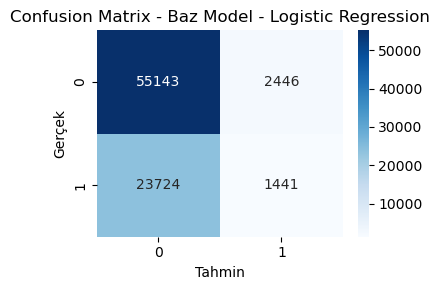

=== Baz Model - Decision Tree ===
Accuracy: 0.6385914880247481
F1 Score: 0.2787691714092794
ROC AUC: 0.5234791086257466

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.71      0.82      0.76     57589
           1       0.35      0.23      0.28     25165

    accuracy                           0.64     82754
   macro avg       0.53      0.52      0.52     82754
weighted avg       0.60      0.64      0.61     82754



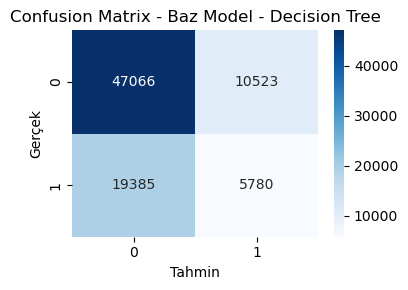

In [9]:
baseline_results = []

# 1) Logistic Regression (baseline)
log_reg = LogisticRegression(max_iter=1000)

baseline_lr_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", log_reg)
])

res_baseline_lr = evaluate_model(
    "Baz Model - Logistic Regression",
    baseline_lr_pipeline,
    X_train, y_train,
    X_test, y_test
)
baseline_results.append(res_baseline_lr)

# 2) Decision Tree (baseline)
dt_clf = DecisionTreeClassifier(random_state=42)

baseline_dt_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", dt_clf)
])

res_baseline_dt = evaluate_model(
    "Baz Model - Decision Tree",
    baseline_dt_pipeline,
    X_train, y_train,
    X_test, y_test
)
baseline_results.append(res_baseline_dt)


## 11. Wisam – Özellik Seçimi (SelectKBest – Chi2)

Bu bölümde Wisam'ın sorumlu olduğu ilk özellik seçimi tekniği uygulanmaktadır:

- **Yöntem:** `SelectKBest(score_func=chi2)`  
- Amaç: Hedef değişken ile en güçlü ilişkiye sahip özellikleri seçmek  
- Not: Chi2, 0'dan büyük sayısal değerler ve one-hot kodlanmış kategorik verilerle iyi çalışır.

Seçilen özellikler ile tekrar:
- Logistic Regression
- Decision Tree

modelleri eğitilecek ve sonuçlar baz model ile karşılaştırılacaktır.


=== Wisam - Logistic Regression + Chi2(SelectKBest) ===
Accuracy: 0.6959059380815429
F1 Score: 0.0
ROC AUC: 0.59187347013505

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     57589
           1       0.00      0.00      0.00     25165

    accuracy                           0.70     82754
   macro avg       0.35      0.50      0.41     82754
weighted avg       0.48      0.70      0.57     82754



C:\Users\Monster\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Monster\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Monster\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


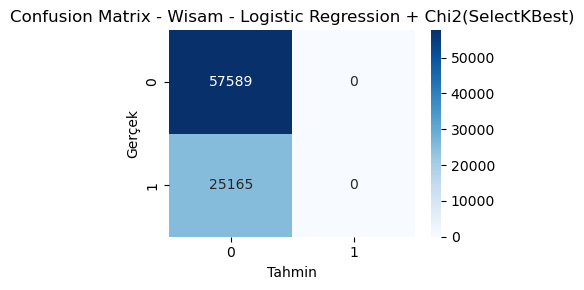

=== Wisam - Decision Tree + Chi2(SelectKBest) ===
Accuracy: 0.5832346472678058
F1 Score: 0.32553045859000684
ROC AUC: 0.5121535437523552

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.70      0.69      0.70     57589
           1       0.32      0.33      0.33     25165

    accuracy                           0.58     82754
   macro avg       0.51      0.51      0.51     82754
weighted avg       0.59      0.58      0.59     82754



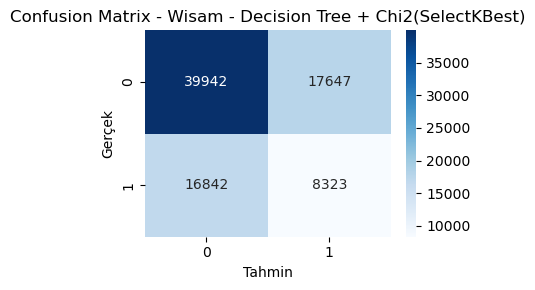

In [10]:
fs_results = []  # Wisam'a ait tüm FS/DR sonuçları burada toplanacak

k_best = 15  # Seçilecek özellik sayısı (gerekirse ayarlanabilir)

chi2_selector = SelectKBest(score_func=chi2, k=k_best)

# 1) Logistic Regression + Chi2
lr_chi2_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("chi2", chi2_selector),
    ("model", LogisticRegression(max_iter=1000))
])

res_lr_chi2 = evaluate_model(
    "Wisam - Logistic Regression + Chi2(SelectKBest)",
    lr_chi2_pipeline,
    X_train, y_train,
    X_test, y_test
)
fs_results.append(res_lr_chi2)

# 2) Decision Tree + Chi2
dt_chi2_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("chi2", chi2_selector),
    ("model", DecisionTreeClassifier(random_state=42))
])

res_dt_chi2 = evaluate_model(
    "Wisam - Decision Tree + Chi2(SelectKBest)",
    dt_chi2_pipeline,
    X_train, y_train,
    X_test, y_test
)
fs_results.append(res_dt_chi2)


## 12. Wisam – Özellik Seçimi (Mutual Information) + Boyut İndirgeme (PCA)

Bu bölümde ikinci özellik seçimi tekniği ve boyut indirgeme birlikte kullanılmaktadır:

- **Özellik Seçimi:** `SelectKBest(score_func=mutual_info_classif)`
- **Boyut İndirgeme:** `PCA`

Amaç:
- Önce hedefle bilgi kazancı yüksek özellikleri seçmek,
- Ardından PCA ile boyutu küçülterek gürültüyü azaltmak,
- Aynı iki modeli (LR ve DT) bu yeni temsil üzerinde tekrar eğitmek.


MI + PCA örneklem üzerinde çalıştırılıyor...


C:\Users\Monster\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\Monster\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\Monster\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


=== Wisam - Logistic Regression + MI + PCA (Sample) ===
Accuracy: 0.6959059380815429
F1 Score: 0.0
ROC AUC: 0.5917462837270748

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     57589
           1       0.00      0.00      0.00     25165

    accuracy                           0.70     82754
   macro avg       0.35      0.50      0.41     82754
weighted avg       0.48      0.70      0.57     82754



C:\Users\Monster\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Monster\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Monster\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


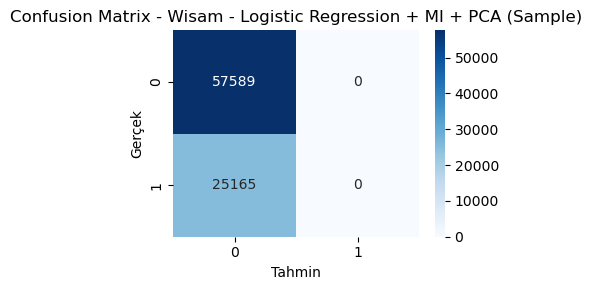

MI + PCA başarıyla tamamlandı.


In [12]:
# ===============================================
# MI + PCA (Örneklem Üzerinde) – Wisam
# ===============================================

print("MI + PCA örneklem üzerinde çalıştırılıyor...")

# 1) Örneklem alma (Bilgisayar kaynakları için zorunlu)
sample_size = 50000  # gerekirse 30k yapabiliriz
X_train_sample = X_train.sample(sample_size, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# 2) MI (Mutual Information)
k_best_mi = 10  

def mi_score(X, y):
    return mutual_info_classif(
        X, y,
        discrete_features='auto',
        n_neighbors=3,
        copy=True,
        random_state=42,
        n_jobs=1
    )

mi_selector = SelectKBest(score_func=mi_score, k=k_best_mi)

# 3) PCA
n_pca_components = 8
pca = PCA(n_components=n_pca_components)

# 4) Logistic Regression + MI + PCA (örneklem üzerinde)
lr_mi_pca_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("mi", mi_selector),
    ("pca", pca),
    ("model", LogisticRegression(max_iter=1000))
])

res_lr_mi_pca = evaluate_model(
    "Wisam - Logistic Regression + MI + PCA (Sample)",
    lr_mi_pca_pipeline,
    X_train_sample, y_train_sample,
    X_test, y_test
)

fs_results.append(res_lr_mi_pca)

print("MI + PCA başarıyla tamamlandı.")

## 13. Sonuçların Karşılaştırılması ve Özet Tablo

Aşağıdaki tabloda:
- Baz modeller
- Chi2 ile özellik seçimi
- Mutual Information + PCA

sonrasında elde edilen metrikler yan yana gösterilmekte ve Wisam'ın katkısı özetlenmektedir.


In [13]:
# Sonuçları DataFrame olarak birleştirelim
import pandas as pd

all_results = []

for r in baseline_results:
    r2 = r.copy()
    r2["kategori"] = "Baz Model"
    all_results.append(r2)

for r in fs_results:
    r2 = r.copy()
    r2["kategori"] = "Wisam - FS/DR"
    all_results.append(r2)

results_df = pd.DataFrame(all_results)
results_df


,name,accuracy,f1,auc,kategori
0,Baz Model - Logistic Regression,0.683762,0.099201,0.569338,Baz Model
1,Baz Model - Decision Tree,0.638591,0.278769,0.523479,Baz Model
2,Wisam - Logistic Regression + Chi2(SelectKBest),0.695906,0.000000,0.591873,Wisam - FS/DR
3,Wisam - Decision Tree + Chi2(SelectKBest),0.583235,0.325530,0.512154,Wisam - FS/DR
4,Wisam - Logistic Regression + MI + PCA (Sample),0.695906,0.000000,0.591746,Wisam - FS/DR
